<a href="https://colab.research.google.com/github/adityachoudharyclg/internshipProjectClg/blob/master/Football_general_autoencoder_adi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import networkx.generators as gen
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
from networkx.algorithms.community import greedy_modularity_communities
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
!wget https://github.com/adityachoudharyclg/internshipProjectClg/archive/master.zip
!unzip master.zip

--2020-07-09 15:51:23--  https://github.com/adityachoudharyclg/internshipProjectClg/archive/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/adityachoudharyclg/internshipProjectClg/zip/master [following]
--2020-07-09 15:51:24--  https://codeload.github.com/adityachoudharyclg/internshipProjectClg/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [    <=>             ] 922.34K   849KB/s    in 1.1s    

2020-07-09 15:51:26 (849 KB/s) - ‘master.zip’ saved [944477]

Archive:  master.zip
f8eedff0b1f0209a18a53eb6b8805a6b95cd6caa
   creating: internshipProjectClg-master/
  infla

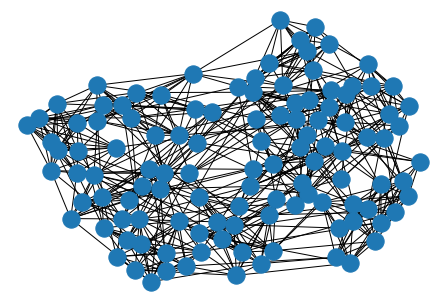

In [34]:
# Load the dataset and return modularity matrix and truth values
def load_dataset(name):
    dolphin_path = 'internshipProjectClg-master/dolphins_gt.gml'
    adjnoun_path = "internshipProjectClg-master/AdjNoun/adjnoun.gml"
    football_path = 'internshipProjectClg-master/Football/football.gml'
    karate_path = 'internshipProjectClg-master/Karate/karate.gml'
    polbooks_path = 'internshipProjectClg-master/PolBooks/polbooks.gml'
    polblogs_path = 'internshipProjectClg-master/Polblogs/polblogs.gml'
    lesmis_path = 'internshipProjectClg-master/lesmis.gml'

    # Polblogs
    if(name=='polblogs'):
        G_data = nx.read_gml(polblogs_path)
        G_data = G_data.to_undirected()
        G_data = nx.Graph(G_data)
        B_data = nx.modularity_matrix(G_data)

    # Karate
    if(name=='karate'):
        G_data=nx.karate_club_graph()
        B_data=nx.modularity_matrix(G_data)
    
    # Football
    if(name=='football'):
        G_data = nx.read_gml(football_path)
        B_data = nx.modularity_matrix(G_data)
    
    # Polbooks
    if(name=='polbooks'):
        G_data = nx.read_gml(polbooks_path)
        B_data = nx.modularity_matrix(G_data)
    
    # Dolphin
    if(name=='dolphin'):
        G_data = nx.read_gml(dolphin_path)
        B_data = nx.modularity_matrix(G_data)
  
    nx.draw(G_data)
    plt.show()
    return G_data, B_data
G_data,B_data=load_dataset('football')
# print(greedy_modularity_communities(G_data))

In [35]:
# Train test split here batch size=train_ds
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [36]:
# Test The data
print(B_data.shape,len(G_data.edges()))

(115, 115) 613


In [37]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        code = self.encoder_output_layer(activation)
        code = torch.tanh(code)
        # code = nn.Dropout(p=0.01)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.tanh(activation)
        # reconstructed = nn.Dropout(p=0.01)(reconstructed)
        return encoder,reconstructed

In [38]:
epochs = 1000
learning_rate = 1e-3

In [39]:
#  use gpu if available
device = torch.device("cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=64,in_layers=B_data.shape[0]).to(device)
model2=AE(hidden_layers=32,in_layers=64).to(device)
model3=AE(hidden_layers=16,in_layers=32).to(device)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model2)

AE(
  (encoder_hidden_layer): Linear(in_features=64, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=64, bias=True)
)


In [40]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [41]:
B_data=np.asarray(B_data,dtype=np.float64)
inputs=torch.from_numpy(B_data)
targets=torch.from_numpy(B_data)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist=train_model(400,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist=train_model(300,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 3 training
encoder,hist=train_model(200,train_dl,model3,optimizer3)
train_dl=givetrain(encoder.detach(),encoder.detach())
# print(encoder)
print(encoder.detach().shape)

epoch : 1/400, recon loss = 0.09304156
epoch : 2/400, recon loss = 0.09094986
epoch : 3/400, recon loss = 0.08907784
epoch : 4/400, recon loss = 0.08739043
epoch : 5/400, recon loss = 0.08585466
epoch : 6/400, recon loss = 0.08444052
epoch : 7/400, recon loss = 0.08312097
epoch : 8/400, recon loss = 0.08187202
epoch : 9/400, recon loss = 0.08067275
epoch : 10/400, recon loss = 0.07950528
epoch : 11/400, recon loss = 0.07835449
epoch : 12/400, recon loss = 0.07720794
epoch : 13/400, recon loss = 0.07605578
epoch : 14/400, recon loss = 0.07489062
epoch : 15/400, recon loss = 0.07370764
epoch : 16/400, recon loss = 0.07250458
epoch : 17/400, recon loss = 0.07128172
epoch : 18/400, recon loss = 0.07004182
epoch : 19/400, recon loss = 0.06878981
epoch : 20/400, recon loss = 0.06753223
epoch : 21/400, recon loss = 0.06627654
epoch : 22/400, recon loss = 0.06503014
epoch : 23/400, recon loss = 0.06379947
epoch : 24/400, recon loss = 0.06258946
epoch : 25/400, recon loss = 0.06140344
epoch : 2

In [42]:
B_data_X=encoder.detach().numpy()

In [45]:
kmeans = KMeans(n_clusters=12,init='k-means++',random_state=461)
kmeans.fit(B_data_X)
X_ae = kmeans.labels_
#---------------------------------------------------------|Ground Truth|-------
c_attributes = nx.get_node_attributes(G_data,'value')
c_groups = []

for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
# c_groups=[0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
# print(G_data.nodes)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[10  3  1  6 10  6  1  7  7 10  6 11  2  1  2  1 10  4  2  0  4  7  7 10
 11  3  2  4 11  0  0  2  1  3  2  0  4  3  2  1  6 10  5  2  9  3  8  1
  9  8 11  7  6  8  2  0  4  9  5  5  1  2  4  5  1  4  9  8  7 11  4  2
  6  8  6  9  4  7  7  0  9  6  9  8  6  2  9  4  8  3 11  9  9 10  0  4
  4  5  6  2  1  0  6  3 10  3  1  6  7  3  8  7  9  4  8]
[ 7  0  2  3  7  3  2  8  8  7  3 10  6  2  6  2  7  9  6  1  9  8  8  7
 10  0  6  9 11  1  1  6  2  0  6  1  5  0  6  2  3  7  5  6  4  0 11  2
  4 11 10  8  3 11  6  1  9  4 11 10  2  6  9 10  2  9  4 11  8 10  9  6
  3 11  3  4  9  8  8  1  5  3  5 11  3  6  4  9 11  0  5  4  4  7  1  9
  9 10  3  6  2  1  3  0  7  0  2  3  8  0  4  8  4  9 11]


0.9239387847184936

In [44]:
max=0
index_max=0
for value in range(0,1000):
    kmeans = KMeans(n_clusters=12,random_state=value,init='k-means++')
    kmeans.fit(B_data_X)
    X_ae = kmeans.labels_
    #---------------------------------------------------------|Ground Truth|-------
    c_attributes = nx.get_node_attributes(G_data,'value')
    c_groups = []

    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
    # Remove this in Other datasets
    # c_groups=[0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]        
   
    X_gt = np.array(c_groups)
    # print(X_ae)
    # print(X_gt)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print(index_max,max)
print(index_max,max)

0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
0 0.8988717276495601
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848913139
27 0.9036344848